In [1]:
%load_ext watermark
%watermark -v -p numpy,scipy,sklearn,pandas,matplotlib

CPython 3.6.7
IPython 7.1.1

numpy 1.14.5
scipy 1.1.0
sklearn 0.20.0
pandas 0.23.4
matplotlib 3.0.2


_이 노트북은 핸즈온 ML 7장에 있는 모든 샘플 코드와 연습문제 해답을 가지고 있습니다._

-여기에서 발생하는 경고는 NumPy에 관련된 것([#10449](https://github.com/scikit-learn/scikit-learn/issues/10449))으로 향후 버전에서는 사라질 것입니다._

# 7장 – 앙상블 학습과 랜덤 포레스트

아래 블로그에 이 챕터에 대한 정리가 있음
https://hoony-gunputer.tistory.com/144

### Ensemble learning
* 앙상블 학습이란 하나로 이어진 여러개의 (SVM, 결정트리, 로지스틱 회귀, 경사하강법)예측기를 사용하여 분류, 회귀등을 하는 것을 앙상블 학습이라고 부른다.
* 여러 번의 시도를 거쳐서 균형 잡힌 결과를 만들어낸다.
* 컴퓨터와 데이터가 많을 때 사용하면 성능이 높아진다.

![image.png](attachment:image.png)

### Random Forest
* https://ko.wikipedia.org/wiki/%EB%9E%9C%EB%8D%A4_%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8
* 랜덤 포레스트는 여러 개의 결정 트리들을 임의적으로 학습하는 방식의 앙상블 방법이다.
* 랜덤 포레스트 방법은 크게 다수의 결정 트리를 구성하는 학습 단계와 입력 벡터가 들어왔을 때, 분류하거나 예측하는 테스트 단계로 구성되어있다. 
* 랜덤 포레스트는 검출, 분류, 그리고 회귀 등 다양한 애플리케이션으로 활용되고 있다.

#### 특징
*  가장 핵심적인 특징은 임의성(randomness)에 의해 서로 조금씩 다른 특성을 갖는 트리들로 구성된다는 점이다. 
* 이 특징은 각 트리들의 예측(prediction)들이 비상관화(decorrelation) 되게하며, 결과적으로 일반화(generalization) 성능을 향상시킨다. 
* 임의화(randomization)는 포레스트가 노이즈가 포함된 데이터에 대해서도 강인하게 만들어 준다. 
  * 임의화는 각 트리들의 훈련 과정에서 진행되며, 가장 널리 쓰이는 두 가지 방법으로는 임의 학습 데이터 추출 방법을 이용한 앙상블 학습법인 배깅(bagging)과 임의 노드 최적화(randomized node optimization)가 있다. 
  * 이 두 가지 방법은 서로 동시에 사용되어 임의화 특성을 더욱 증진 시킬 수 있다

# 설정

파이썬 2와 3을 모두 지원합니다. 공통 모듈을 임포트하고 맷플롯립 그림이 노트북 안에 포함되도록 설정하고 생성한 그림을 저장하기 위한 함수를 준비합니다:

In [2]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

# png로 이미지 저장
def save_fig(fig_id, tight_layout=True):
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

# 투표기반 분류기

### 직접투표분류기(hard voting)

* 각 분류기의 예측을 모아 가장 많이 선택된 클래스 예측(다수결 투표)
    * 개별 분류기 중 가장 뛰어난 것보다 정확도가 높은 경우가 많다.
    * 약한 학습기라도 앙상블을 사용하면 강한 학습기가 될 수 있다.
* 큰 수의 법칙
    * 분류기가 완벽하고 독립적이고 오차에 상관관계가 없어야 앙상블이 좋은 성능을 발휘함.

In [3]:
# 동전이 윗면이 나올 확률(임의로 정해본 값)
heads_proba = 0.51

# np.random.rand(n,m)은 0~1사이의 실수를 랜덤하게 n*m 개 반환한다.
# 각 랜덤 실수에 대해 heads_proba보다 작으면 1, 크면 0으로 변환한다.
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)

# np.cumsum(arr, axis)는 axis를 기준으로 누적합을 계산하여 반환한다.
# axis가 여기서 0이므로 column끼리 누적합임.(2차원이라서 이렇게 설명하면 쉬움)
# np.arange(start, end)는 start부터 end-1까지 1차원 배열로 반환한다. start를 생략하면 0부터 시작한다.
# 이걸 reshape(-1,1)했으므로 숫자 하나당 배열 하나를 잡도록 했다.
# 즉, (-1, 1) 혹은 (None, 1) shape이다.
# np.cumsum() / np.arange().reshape(-1,1)의 shape를 보면 (10000, 10) / (10000, 1) 이런 형태다.
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

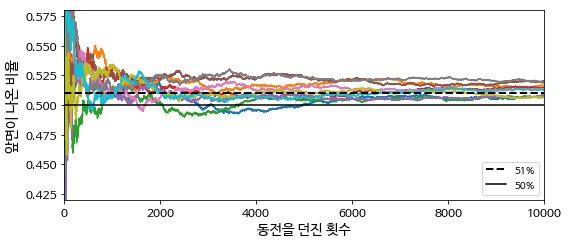

In [22]:
plt.figure(figsize=(8,3.5))
# 10개의 선이 생김. 
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("동전을 던진 횟수")
plt.ylabel("앞면이 나온 비율")
# 범례 위치 설정
plt.legend(loc="lower right")
# 축 설정 [x 시작, x 끝, y 시작, y 끝]
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

# moon dataset 생성       
# n_samples : 생성할 points 개수 (기본 : 100)
# shuffle : 셔플 여부 (기본 : True)
# noise : 퍼짐 정도 (기본 None) ; 가우시안 표준편차를 노이즈로 삽입
# random_state : 랜덤 상태 (기본 : None)
y = make_moons(n_samples=500, shuffle=True , noise=0.30, random_state=42)
# training, test set으로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

ValueError: setting an array element with a sequence.

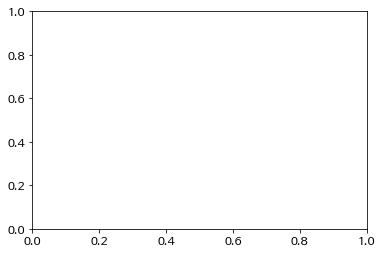

* 사이킷런 0.22 버전에서 `LogisticRegression`의 solver 매개변수의 기본값이 `'liblinear'`에서 `'lbfgs'`로 변경될 예정입니다. 책의 결과와 맞추기 위해 명시적으로 `'liblinear'`로 설정합니다. 
* 0.22 버전에서 `RandomForestClassifier`의 `n_estimators` 매개변수 기본값이 100으로 바뀝니다. 경고를 내지 않도록 하기 위해 현재 기본값인 10으로 설정합니다. 
* 0.22 버전에서 `SVC`의 `gamma` 매개변수의 기본값이 스케일 조정되지 않은 특성을 위해 `'scale'`로 변경됩니다. 기존 방식을 사용하고 경고를 없애기 위해 `'auto'`로 설정합니다.

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# logistic regression classifier
log_clf = LogisticRegression(solver='liblinear', random_state=42)
# random forest classifier
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
# support vector machine classifier
svm_clf = SVC(gamma='auto', random_state=42)

# 투표 분류기 
# 서로 다른 모델로 앙상블 학습
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', Rando...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [8]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


In [8]:
log_clf = LogisticRegression(solver='liblinear', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma='auto', probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', Rando...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [9]:
from sklearn.metrics import accuracy_score

# training set으로 정확도 확인
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


# 배깅 & 페이스팅
* 배깅(bagging : bootstrap aggregating의 준말) : training set에서 중복을 허용하여 샘플링하는 방식
* 페이스팅(pasting) : 중복을 허용하지 않고 샘플링하는 방식
* 배깅과 페이스팅은 같은 훈련샘플을 여러 개의 예측기에 사용할 수 있다. 하지만 배깅만 같은 훈련샘플을 여러 번 샘플링 할 수 있다.
* 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만듦. 수집함수는 전형적 분류일 때는 통계적 최빈값이고 회귀에 대해서는 평균을 계산한다.
* 일반적으로 원본 데이터 셋을 하나의 예측기에 훈련시킬 때와 비교해서 앙상블의 결과는 편향이 비슷하지만 분산이 줄어드는 효과를 지닌다.
* 병렬수행이 가능한 확장성 때문에 배깅과 페이스팅은 유용하다.

In [11]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
# bootstrap : True면 배깅, False면 페이스팅
# n_jobs : cpu 코어수 / -1은 사용가능한 모든 코어 사용한다는 의미
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [12]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [13]:
# 결정트리 하나로 해보자( 비교군)
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [14]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

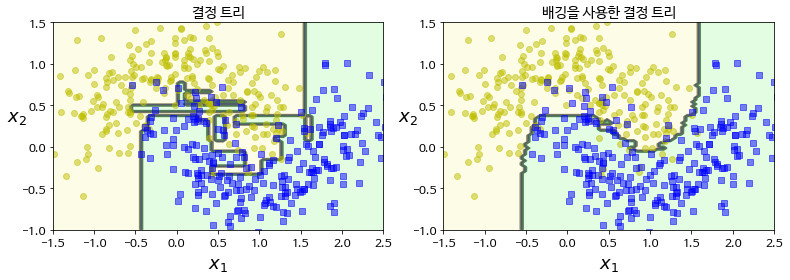

In [15]:
# 단일결정트리의 결정경계
# 500개 트리를 사용한 배깅앙상블의 결정경계 비교 앙상블이 일반화가 더 잘된다. 
# 비슷한 편향에서 더 작은 분산.(=훈련셋의 오차는 비슷하지만 결정경계가 덜 불규칙함.)
# 부트 스트래핑은 서브셋의 다양성이 증가하므로 배깅이 페이스팅보다 편향이 조금 더 높다. 하지만 상관관계를 줄이는 효과가 있어 분산을 감소시킴. 
# 둘다 평가하는 것이 좋긴함.

plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("결정 트리", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("배깅을 사용한 결정 트리", fontsize=14)
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

## oob(out of bag)평가 

- 배깅의 경우 어떤 샘플은 여러 번 샘플링되고 어떤 것은 전혀 선택이 되지 않을 수 있다. 
- 훈련 샘플 중 선택되지 않은 나머지를 oob샘플이라고 함.
- 훈련되는 동안 전혀 사용되지 않으므로 검증셋이나 교차 검증을 사용하지 않고 oob샘플을 사용해서 앙상블을 평가할 수 있다.

In [24]:
# oob_score를 True로 지정하면 학습 후에 알아서 oob평가를 수행한다.
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

In [25]:
# 결정함수는 oob_decision_function에서 확인 가능하다.
bag_clf.oob_decision_function_

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08379888, 0.91620112],
       [0.31693989, 0.68306011],
       [0.02923977, 0.97076023],
       [0.97687861, 0.02312139],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.71195652, 0.28804348],
       [0.83957219, 0.16042781],
       [0.97777778, 0.02222222],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97297297, 0.02702703],
       [0.95238095, 0.04761905],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.38947368, 0.61052632],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.96685083, 0.03314917],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.64804469, 0.35195531],
       [0.

In [26]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
# 배깅만 한것보다 결과 더 좋음
accuracy_score(y_test, y_pred)

0.912

# Random Patches & Random Subspaces
-  BaggingClassifier class는 features를 샘플링하는 것도 지원한다. 
    - 샘플링은 두 가지 hyperparameters(max_features, bootstrap_features)로 통제
    - max_samples와 bootstrap과 동일한 방식으로 작동한다. 다른 점은 instance sampling이 아니라 feature sampling 한다는 점
- 이미지와 같은 고차원 inputs을 다루는 데에 특히 유용하다.
- training instances와 features를 모두 샘플링하는 것을 Random Patches method라고 한다
- 모든 training instances를 유지하고(bootstrap=False & max_samples=1.0) features는 sampling(bootstrap_features=True and/or max_features < 1.0)하는 것을 Random Subspaces method라고 한다.
- Sampling features는 더 다양한 예측기를 만들 수 있고 편향을 늘리고 분산을 낮춘다.

# 랜덤 포레스트 Random Forests
- 배깅을 적용한 결정트리 앙상블
- max_samples 를 훈련세트의 크기로 지정
- 배깅 클레스파이어 대신 결정트리에 최적화된 랜덤포레스트클레시파이어 사용가능함.
- 트리의 노드를 분할 할 때 전체 특성 중 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보중 최적의 특성을 찾는 식으로 무작위성을 주입한다. 이것이 트리를 다양하게 만들고 편향을 손해보는 대신 분산을 낮추므로 전체적으로는 더 좋은 모델이 된다.

### random forest v1 

In [16]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

In [17]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

### random forest v2 

In [18]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [19]:
# 예측값이 같으면 1 다르면 0으로 하여 그 모든 값들을 더하여 예측값 길이로 나눔
# 1에 가까울수록 두 모델 예측이 비슷하다는 것
# 결과를 보면 거의 동일하다.
np.sum(y_pred == y_pred_rf) / len(y_pred)  # 거의 동일한 예측

0.976

## 특성 중요도
- 랜덤포레스트는 특성의 상대적 중요도를 측정하기 쉽다.
- 사이킷런은 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정.
- 가중치의 평균과 각 노드의 가중치는 연관된 훈련의 샘플 수와 같다.
- 사이킷런에서는 훈련이 끝난 후 특성마다 자동으로 점수를 계산하고 중요도의 전체합이 1이 되도록 결과를 정규화시켜준다.

####  붓꽃(iris) 데이터로 확인하기

In [20]:
from sklearn.datasets import load_iris
iris = load_iris()
# 결정트리가 500개인 랜덤포레스트
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876374
sepal width (cm) 0.023119288282510326
petal length (cm) 0.44103046436395765
petal width (cm) 0.4233579963547681


In [20]:
# 특성마다 중요도를 지닌다.
# 중요도의 합은 1이다.
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

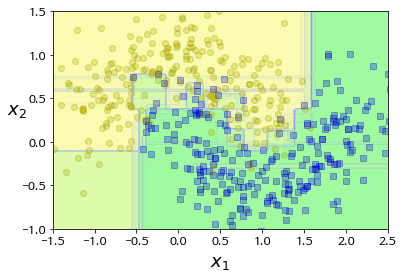

In [23]:
plt.figure(figsize=(6, 4))

# 15번 반복한다. 겹쳐서 보여지게 함.
for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

#### MNIST dataset으로 확인 

In [25]:
# from sklearn.datasets import fetch_mldata
# mnist = fetch_mldata('MNIST original')
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [26]:
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [27]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

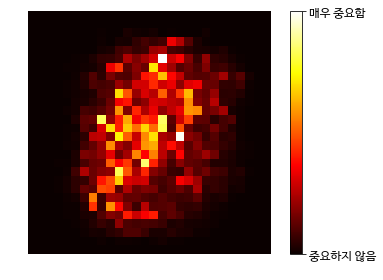

In [28]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['중요하지 않음', '매우 중요함'])

save_fig("mnist_feature_importance_plot")
plt.show()

# 부스팅 boosting
- 원래는 hypothesis boosting
- 약한 학습기를 여러개 연결하여 강한 학습기를 만드는 앙상블 방법 
- 일반적인 부스팅 방법은 예측기를 sequentially 학습시키고 각 예측기를 고치는 것이다.
- AdaBoost(Adaptive Boosting의 준말)와 Gradient Boosting을 제일 많이 사용한다.

## 아다부스트 AdaBoost

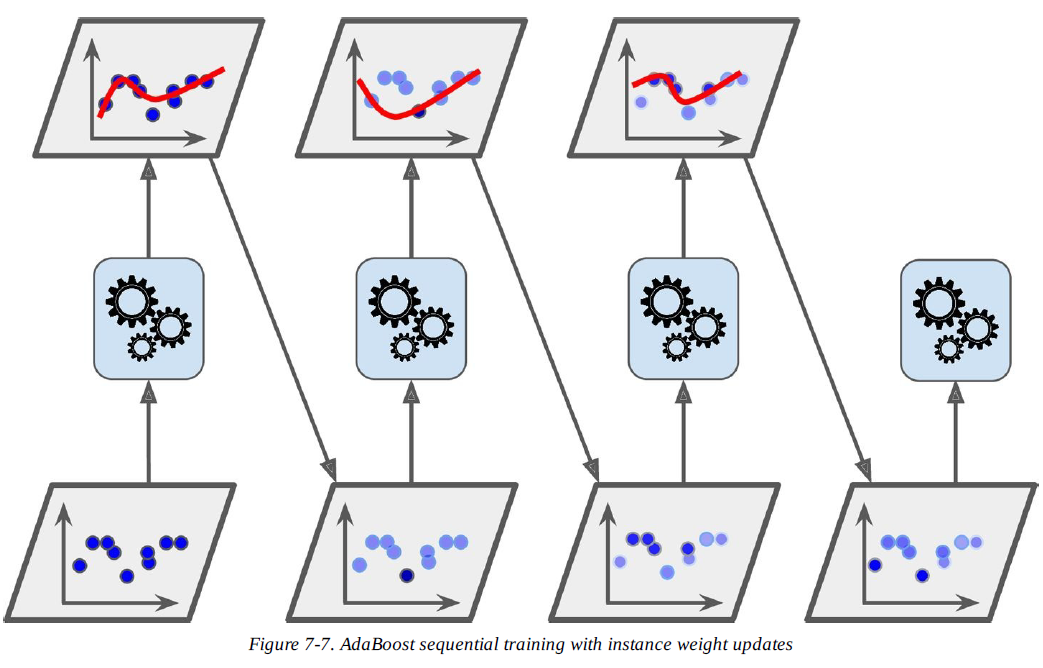

- 이전 예측기를 보완하는 새로운 예측기를 만드려면 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것이며 새로운 예측기는 학습하기 어려운 샘플에 더 맞추어진다. 이 방법이 아다부스트에서 사용되는 방법이다.
- 첫번째 분류기 훈련 -> 잘못분류된 훈련샘플가중치 높이기 -> 두번째 분류기에서 업데이트된 가중치 사용하여 훈련, 다시 예측 -> 업데이트

### AdaBoost algorithm
- weight는 1/m으로 초기화

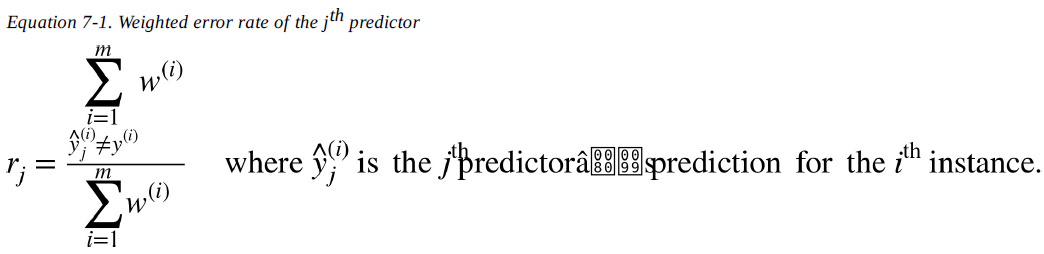

Equation 7-2. predictor weight
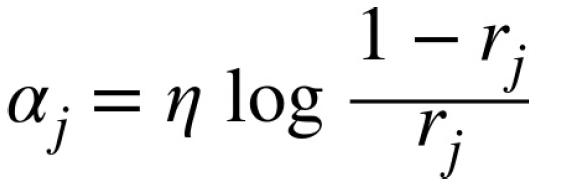

_Equation 7-3. Weight update rule_
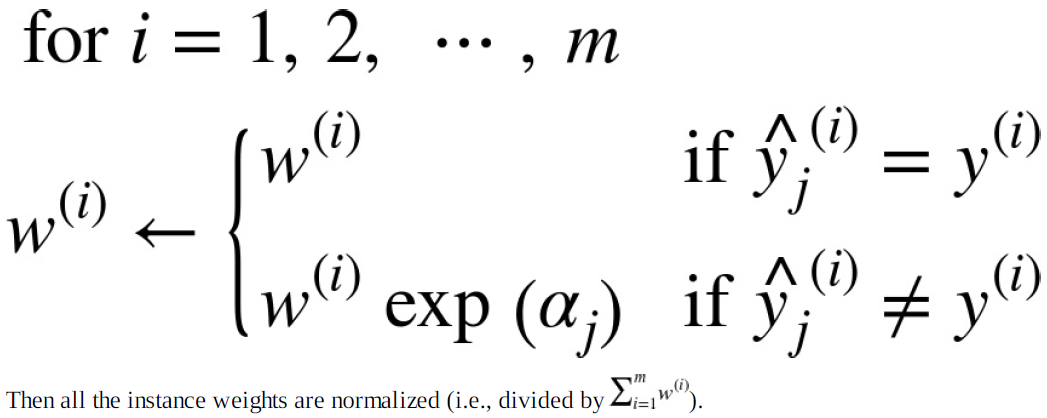

* 새로운 예측기가 업데이트된 weights로 학습되고 
* 이 프로세스는 반복된다.
* 설정한 예측기 숫자에 도달하거나 완벽한 예측기가 발견되면 알고리즘은 멈춘다.

* 예측시에 AdaBoost는 예측기 가중치 $ \alpha_j $를 사용하여 모든 예측기의 예측값과 가중치를 계산한다.

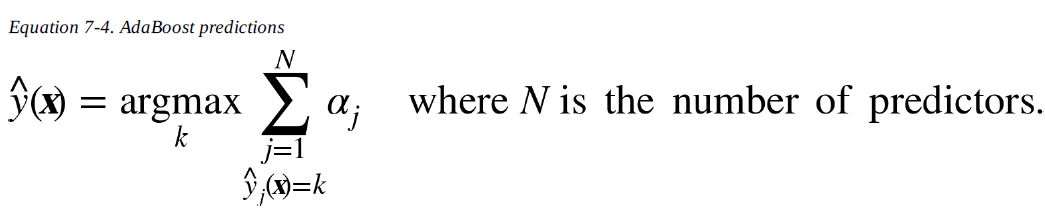

In [27]:
from sklearn.ensemble import AdaBoostClassifier

# 200개의 얕은 결정트리를 기반으로 함
# Scikit-learn은 AdaBoost의 multiclass version을 사용한다 
# 이를 SAMME라고 부른다
# (Stagewise Additive Modeling using a Multiclass Exponential loss function)
# R은 Real을 뜻함.
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

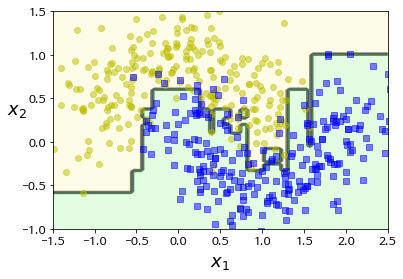

In [28]:
plot_decision_boundary(ada_clf, X, y)

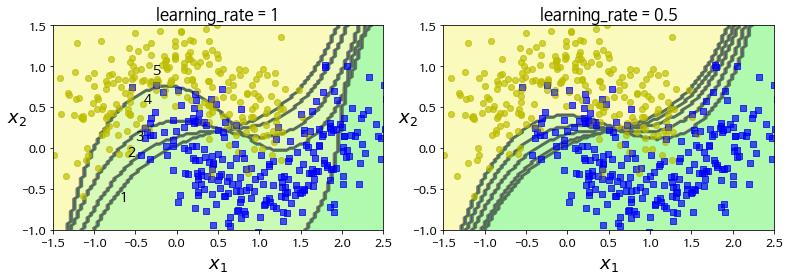

In [31]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    if subplot == 121:
        # 1~5까지는 처음 예측기 결과~ 마지막 예측기 결과를 집어주는 역할
        # 5로 갈수록 예측기가 더 나아진다.
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)        
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma='auto', random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)

save_fig("boosting_plot")
plt.show()

In [32]:
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))

['base_estimator_',
 'classes_',
 'estimator_errors_',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'n_classes_']

# 그래디언트 부스팅 Gradient Boosting
* AdaBoost와 동일하게 이전 예측기를 올바르게 고치면서 sequential하게 예측기를 앙상블에 추가한다.
* 아다부스트는 매 iteration마다 instance의 가중치를 수정하는 데 반해, GB는 이전 예측기가 만든 잔여 오차(residual errors)에 새로운 예측기를 학습

In [29]:
# 데이터 만들기
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

### gradient boosting을 manual하게 구성해보기

In [30]:
from sklearn.tree import DecisionTreeRegressor
# 처음 예측기
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [31]:
# 이전 예측기의 오차를 활용하여 다음 예측기를 학습
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [32]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [33]:
X_new = np.array([[0.8]])

In [34]:
# 모든 예측기의 합을 이용하여 예측한다.
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [35]:
y_pred

array([0.75026781])

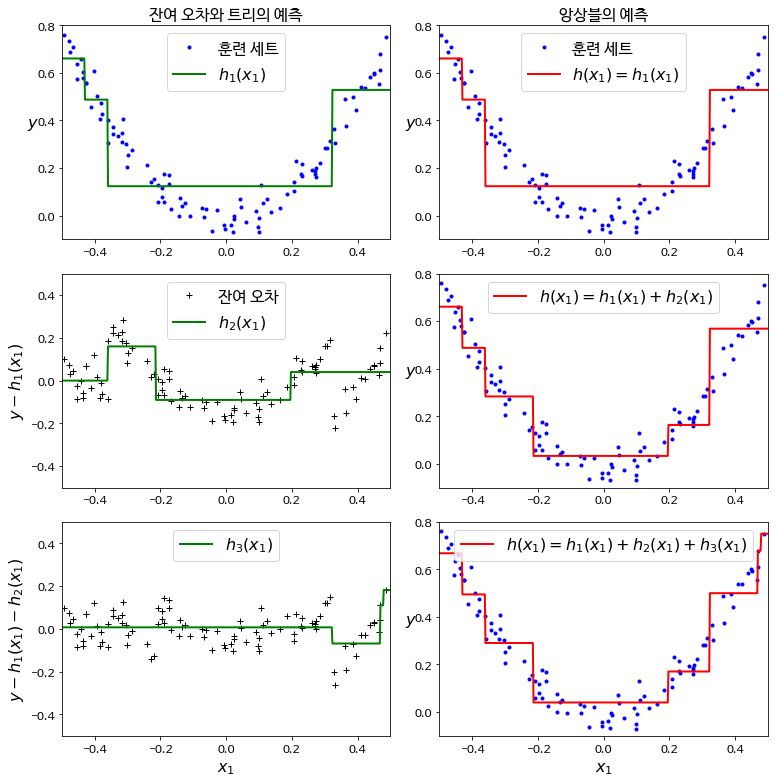

In [36]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="훈련 세트")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("잔여 오차와 트리의 예측", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="훈련 세트")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("앙상블의 예측", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="잔여 오차")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

### 만들어져있는 gradient boosting 사용하기
* 추가적으로 예측기를 몇개로 넣을지 문제에 대해 생각해보자
* 예측기가 부족하면 underfit, 너무 많으면 overfit될 것이다.
* 적절한 예측기 개수를 삽입하는 것이 중요하다.

In [37]:
from sklearn.ensemble import GradientBoostingRegressor

# 예측기가 3개짜리임 : 부족함
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=0.1, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [38]:
# 예측기가 200개짜리임 : 너무 많음
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

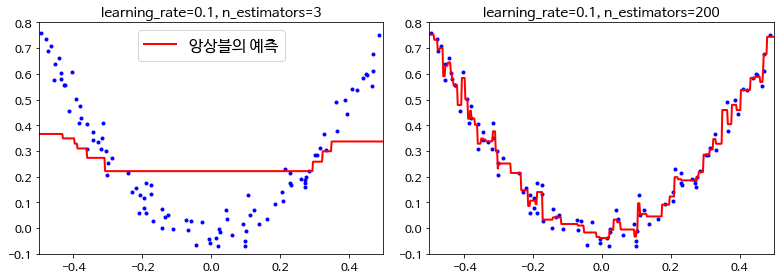

In [39]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="앙상블의 예측")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

save_fig("gbrt_learning_rate_plot")
plt.show()

## 조기 종료를 사용한 그래디언트 부스팅
- 최적의 트리 개수를 정할 때, 조기 종료를 사용하면 된다.
- staged_predict()를 사용
    - training의 각 스테이지에서 앙상블에 의해 만들어진 예측값들에 대한 iterator를 반환

In [40]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
# 에러가 가장 작은 예측기의 개수를 가져옴
bst_n_estimators = np.argmin(errors)
# 여기서 최적 개수는 55개
gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=55, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [41]:
min_error = np.min(errors)

In [42]:
bst_n_estimators

55

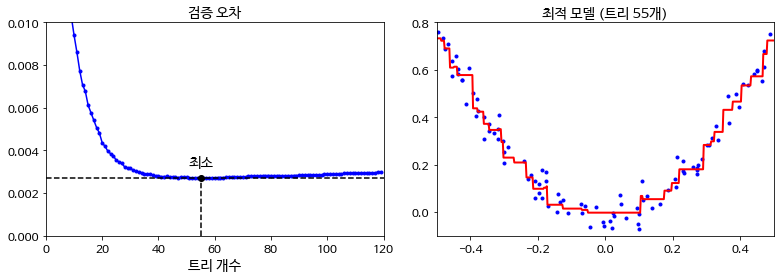

In [46]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "최소", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("트리 개수")
plt.title("검증 오차", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("최적 모델 (트리 %d개)" % bst_n_estimators, fontsize=14)

save_fig("early_stopping_gbrt_plot")
plt.show()

#### training을 실제로 조기 종료하는 방법을 사용할 수도 있다.
- warm_start=True
    - fit()이 요청되었을 때, incremental training을 허용하여 Scikit-Learn이 기존의 트리를 유지하게 한다.
- 다음의 코드는 validation error가 5번이나 연속으로 나아지지 않으면 training을 종료한다.

In [47]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
# 예측기 개수를 늘리면서 확인한다.
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    # 오차 계산 (MSE)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else: # 최소 에러값보다 크면
        error_going_up += 1 # 하나 증가
        if error_going_up == 5: # 5가 도달하면
            break  # 조기 종료

In [48]:
print(gbrt.n_estimators)

61


In [49]:
print("최소 검증 MSE:", min_val_error)

최소 검증 MSE: 0.002712853325235463


# XGBoost

In [47]:
try:
    import xgboost
except ImportError as ex:
    print("에러: xgboost 라이브러리가 설치되지 않았습니다.")
    xgboost = None

에러: xgboost 라이브러리가 설치되지 않았습니다.


In [45]:
if xgboost is not None:  # 책에는 없음
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print("검증 MSE:", val_error)

In [46]:
if xgboost is not None:  # 책에는 없음
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print("검증 MSE:", val_error)

In [53]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

3.47 ms ± 41.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [54]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

9.7 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# 스태킹 Stacking
- stacked generalization의 준말
- 앙상블엣 모든 예측기의 예측값을 aggregate하기 위해 사소한 functions(ex hard voting)를 이용하지 말고 이 aggregation을 모델이 수행하도록 학습시켜보는 것
- 아래 그림 7-12는 새로운 인스턴스에 대한 회귀 과제를 수행하는 과정을 보여준다.
    - 아래의 3개의 예측기는 서로 다른 3개의 값(3.1, 2.7, 2.9)을 예측한다.
    - 마지막 예측기(blender or meta learner)가 아래의 3개 값을 input으로 받고 마지막 예측(3.0)을 한다.

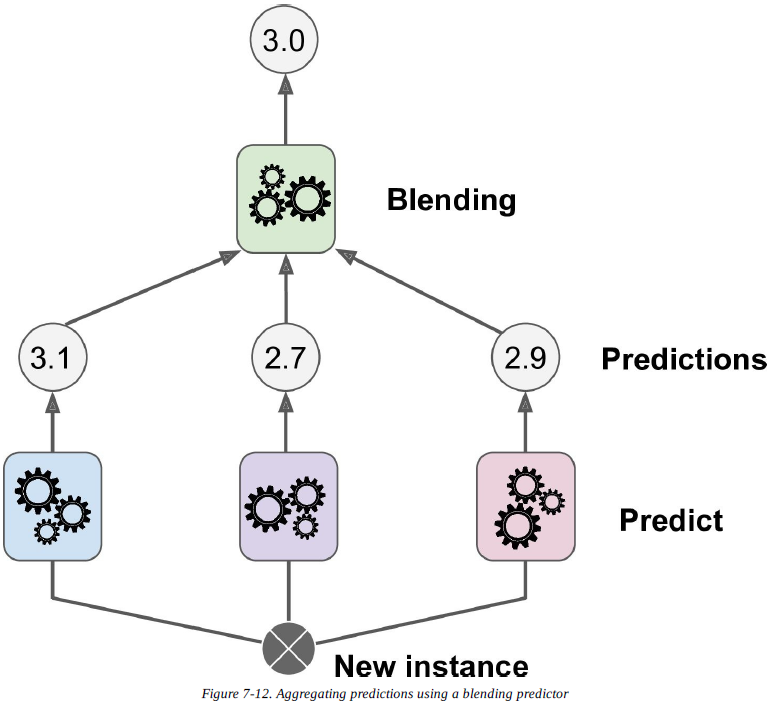

#### blender를 학습시키기 위해서는
* 보통 hold-out set을 이용한다
* 먼저 training set을 2개의 subset으로 분리한다.
* 첫번째 subset은 첫번째 층에서 예측기를 학습시키는데 사용된다.

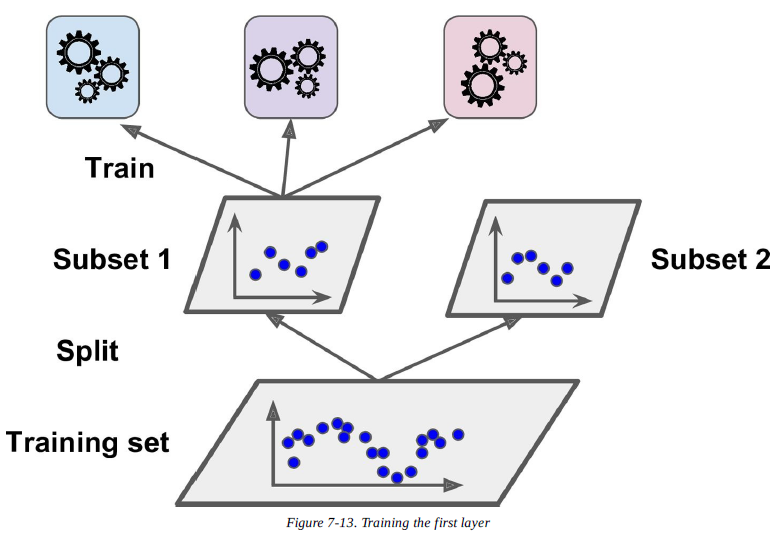

- 다음으로 첫번째 층의 예측기들은 두번째 (held-out) set에서 예측값을 만드는 데에 사용된다. 
    - subset2 예측기들이 subset1 인스턴스들을 training동안 본 적이 없기 때문에 예측값이 깨끗한(clean) 것을 보장한다.
    - hold-out set에서 3개의 예측값을 가진다.
    - 이 3개의 예측값을 input으로 한 새로운 training set을 만든다.(3개의 차원을 지님)
    - target values는 유지한다.
    - blender는 새로운 training set에서 학습
        - 첫 번째 층의 예측값이 주어졌을 때 target value를 예측하도록 학습한다.

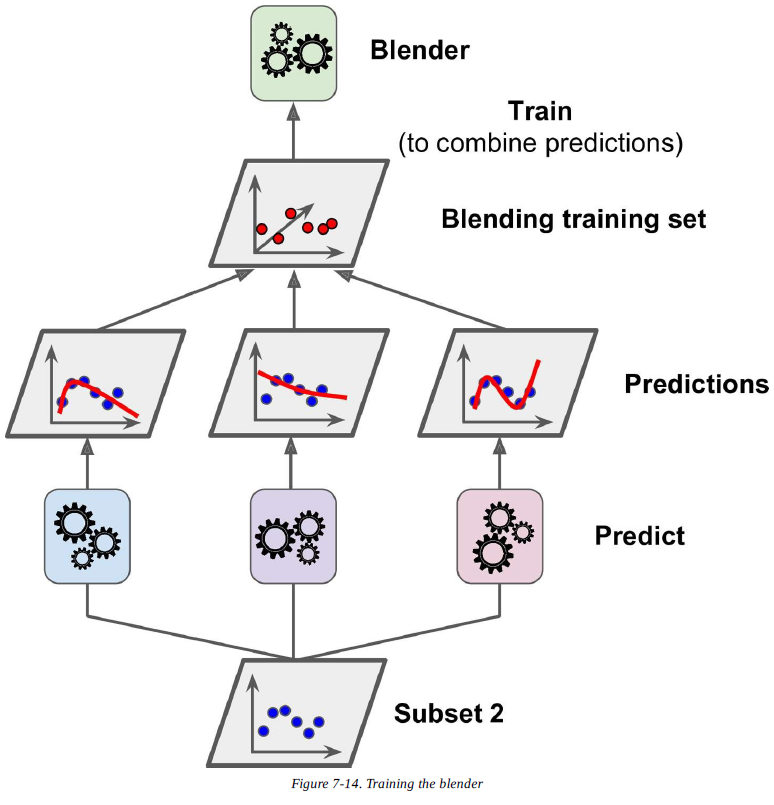

* 서로 다른 blender들을 학습시키는 방식은 실제로 가능하다.예를 들어 하나는 선형 회귀를 이요하고 다른 것은 랜덤포레스트를 이용하는 것이다.
* 트릭은 training set을 3개의 subsets으로 분리하는 것이다. 
    - 첫번째는 첫 번째 층을 학습시키는데 사용되고
    - 두번째는 두 번째 층을 학습시키기 위해 사용되는 training set을 만들 때 사용된다.
        - 두번째 층은 첫번째 층의 예측기에 의해 만들어진 예측값을 사용한다.
    - 세번째는 세 번째 층을 학습시키기 위해 사용되는 training set을 만들 때 사용된다.
        - 세 번째 층은 두 번째 층의 예측기에 의해 만들어진 예측값을 사용한다.
* 앞선 과정이 끝나면 sequential하게 각 층을 지나면서 새로운 인스턴스에 대한 예측값을 만들 수 있다.


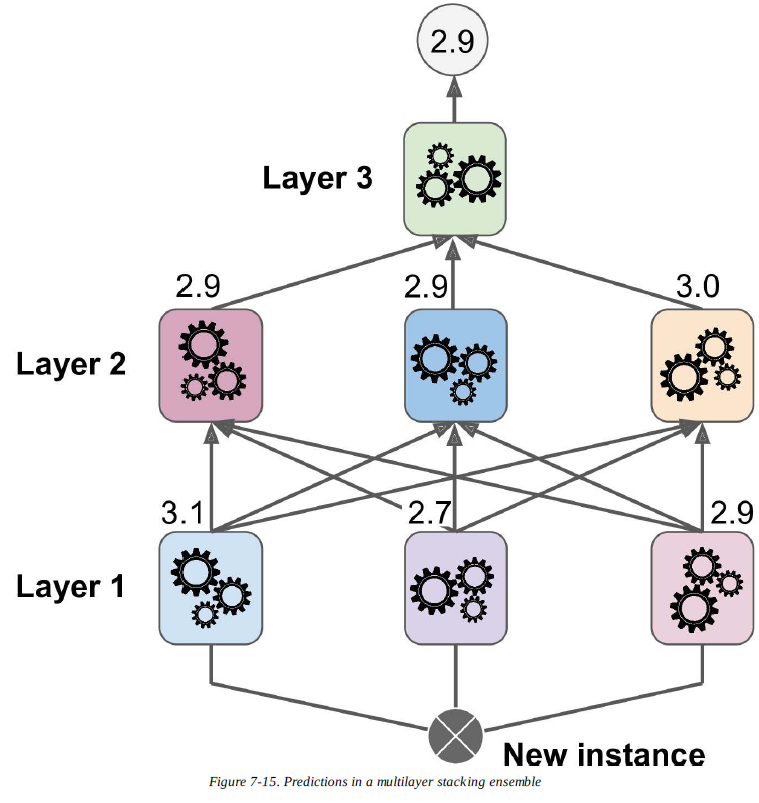

* Scikit-Learn에는 stacking을 직접적으로 지원하는 것이 없다.
* 직접 구현은 할 수 있다.
* 다른 사람이 구현해 놓은 것이 있다.[DESlib](https://github.com/Menelau/DESlib)